In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools
import random
import requests
import os
import json
import time
import psutil

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [39]:
ensemble_size_df = pd.read_csv('../dataset_preparation/df_features_with_ensemble_size_2.csv')
ensemble_size_df.head()

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1,exponential_smoothing,arima,xgboost,random_forest,model_rank,ensemble_size
0,artificialNoAnomaly/art_daily_no_noise.csv,NaN,4032,-45.198782,0.046765,5.000000e-01,1.000000e-04,2.500000e-01,1.050000e-62,1,...,2.970000e-26,-0.500000,0.250000,0.928571,22.402977,25.282784,0.011355,0.003701,"['random_forest', 'xgboost', 'exponential_smoo...",1
1,artificialNoAnomaly/art_daily_perfect_square_w...,NaN,4032,-63.887428,0.043267,5.000000e-01,1.750000e-01,2.000000e-01,0.000000e+00,1,...,0.000000e+00,-0.500000,0.250000,0.928571,22.385788,26.668146,0.009475,0.000024,"['random_forest', 'xgboost', 'exponential_smoo...",1
2,artificialNoAnomaly/art_daily_small_noise.csv,0.412716,4032,-57.839587,0.046790,1.490000e-08,1.010000e-08,3.110000e-21,1.280000e-05,1,...,8.206679e-02,-0.620340,0.418001,0.918527,22.720717,25.473923,2.009846,2.076357,"['xgboost', 'random_forest', 'exponential_smoo...",2
3,artificialNoAnomaly/art_noisy.csv,0.507001,4032,-4126.670693,0.299753,1.580000e-08,7.610000e-09,2.480000e-06,5.353556e-03,1,...,2.664287e-01,-0.676908,0.497557,0.005106,2.872416,2.820160,2.820342,2.883200,"['xgboost', 'exponential_smoothing', 'random_f...",1
4,artificialWithAnomaly/art_daily_flatmiddle.csv,0.501646,4032,-49.327420,0.121571,5.372404e-01,1.590000e-07,2.630000e-07,1.456821e-02,1,...,1.705510e-02,-0.553618,0.314774,0.833093,33.442868,39.067347,13.022835,13.046776,"['xgboost', 'random_forest', 'exponential_smoo...",1


In [40]:
ensemble_size_df.columns

Index(['unique_id', 'hurst', 'series_length', 'unitroot_pp', 'unitroot_kpss',
       'hw_alpha', 'hw_beta', 'hw_gamma', 'stability', 'nperiods',
       'seasonal_period', 'trend', 'spike', 'linearity', 'curvature', 'e_acf1',
       'e_acf10', 'seasonal_strength', 'peak', 'trough', 'x_pacf5',
       'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1', 'exponential_smoothing', 'arima', 'xgboost',
       'random_forest', 'model_rank', 'ensemble_size'],
      dtype='object')

In [41]:
column_mapping = {
    'series_length':'series_length',
    'stability': 'stability',
    'lumpiness': 'lumpiness',
    'crossing.points.fraction': 'crossing_points',  
    'flat.spots.fraction': 'flat_spots',  
    'nonlinearity': 'nonlinearity',
    'ur.kpss': 'unitroot_kpss',
    'ur.pp': 'unitroot_pp',
    'arch.lm': 'arch_lm',
    'ACF1': 'x_acf1',
    'ACF10.SS': 'x_acf10',
    'ACF.seas': 'seas_acf1',
    'PACF10.SS': 'x_pacf5',
    'PACF.seas': 'seas_pacf',
    'hurst': 'hurst',
    'ensemble_size':'ensemble_size'
}

# Check for columns that are not present in the original DataFrame
missing_columns = [col for col in column_mapping.values() if col not in ensemble_size_df.columns]

missing_columns

[]

In [42]:
# Filter the DataFrame
df = ensemble_size_df[[col for col in column_mapping.values() if col in ensemble_size_df.columns]]
df

,series_length,stability,lumpiness,crossing_points,flat_spots,nonlinearity,unitroot_kpss,unitroot_pp,arch_lm,x_acf1,x_acf10,seas_acf1,x_pacf5,seas_pacf,hurst,ensemble_size
0,4032,1.050000e-62,0.000000,28,168.0,0.070376,0.046765,-45.198782,0.960470,0.989173,8.854128,0.928571,0.978583,-0.007057,NaN,1
1,4032,0.000000e+00,0.000000,28,180.0,-0.000293,0.043267,-63.887428,0.970557,0.985036,8.440207,0.928571,0.970529,-0.006061,NaN,1
2,4032,1.280000e-05,0.000102,490,168.0,2.349718,0.046790,-57.839587,0.726378,0.977531,8.643415,0.918527,1.027842,0.205044,0.412716,2
3,4032,5.353556e-03,0.003807,2049,4.0,0.007447,0.299753,-4126.670693,0.003419,-0.009305,0.001607,0.005106,0.000451,0.007050,0.507001,1
4,4032,1.456821e-02,0.074039,50,276.0,0.741962,0.121571,-49.327420,0.859136,0.985528,8.769812,0.833093,0.984697,0.138940,0.501646,1
5,4032,2.104731e-02,0.061766,494,168.0,2.052138,0.098380,-55.541723,0.781880,0.978055,8.682667,0.861524,1.028455,0.172089,0.523080,2
6,4032,4.711886e-02,0.564556,481,176.0,0.039223,0.260825,-53.046075,0.922626,0.980089,8.726534,0.817634,1.027627,0.142922,0.565294,1
7,4032,4.757963e-02,0.076025,655,456.0,2.275400,0.185286,-52.591420,0.783589,0.979942,8.714155,0.796279,1.015332,0.142267,0.553390,2
8,4032,4.910010e-04,0.021647,167,93.0,-0.005879,0.008390,-4751.528222,0.298665,-0.009269,0.224518,-0.020033,0.001304,-0.011985,0.324410,2
9,4032,1.664999e-01,1.929794,374,212.0,0.164389,1.734170,-1639.435252,0.270885,0.605997,0.637076,0.009672,0.393273,0.017855,NaN,3


In [43]:
# Find null values in each column
null_values_per_column = df.isnull().sum()

# Print the result
print("Null values per column:")
print(null_values_per_column)

Null values per column:
series_length       0
stability           0
lumpiness           0
crossing_points     0
flat_spots          0
nonlinearity        0
unitroot_kpss       0
unitroot_pp         0
arch_lm             0
x_acf1              0
x_acf10             0
seas_acf1           0
x_pacf5             0
seas_pacf           0
hurst              10
ensemble_size       0
dtype: int64


In [44]:
def split_df(df):
    # Extract Y_df with the specified columns
    Y_df = df['ensemble_size']
    
    # Extract X_df excluding the specified columns
    X_df = df.drop(columns='ensemble_size')
    
    return X_df, Y_df

In [45]:
# Apply the function
X_df, Y_df = split_df(df)

In [46]:
Y_df

0     1
1     1
2     2
3     1
4     1
5     2
6     1
7     2
8     2
9     3
10    1
11    1
12    1
13    2
14    1
15    3
16    1
17    1
18    1
19    3
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    3
34    1
35    1
36    1
37    1
38    1
39    2
40    3
41    3
42    3
43    1
44    1
45    1
46    1
47    3
48    3
49    2
Name: ensemble_size, dtype: int64

In [47]:
# Assuming df is your DataFrame
X_df.fillna(0, inplace=True)

In [48]:
def scale_out_of_range_columns(df):
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Identify columns with values outside the range [0, 1]
    cols_to_scale = df.columns[(df.min() < 0) | (df.max() > 1)]
    
    # Scale the identified columns
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    
    return df

In [49]:
X_df_scaled = scale_out_of_range_columns(X_df)

X_df_scaled

,series_length,stability,lumpiness,crossing_points,flat_spots,nonlinearity,unitroot_kpss,unitroot_pp,arch_lm,x_acf1,x_acf10,seas_acf1,x_pacf5,seas_pacf,hurst
0,0.130084,1.023935e-62,0.000000,0.000000,0.031721,0.026075,0.001209,0.998132,0.960470,0.993207,0.914046,1.000000,0.669437,0.268085,0.000000
1,0.130084,0.000000e+00,0.000000,0.000000,0.034043,0.001910,0.001099,0.997188,0.970557,0.989574,0.871307,1.000000,0.663925,0.271520,0.000000
2,0.130084,1.248225e-05,0.000007,0.076200,0.031721,0.805490,0.001210,0.997494,0.726378,0.982980,0.892289,0.989411,0.703150,1.000000,0.259149
3,0.130084,5.220660e-03,0.000261,0.333333,0.000000,0.004557,0.009181,0.792060,0.003419,0.116074,0.000000,0.026501,0.000000,0.316763,0.318351
4,0.130084,1.420657e-02,0.005069,0.003629,0.052611,0.255722,0.003566,0.997924,0.859136,0.990005,0.905340,0.899349,0.673621,0.771888,0.314989
5,0.130084,2.052484e-02,0.004228,0.076860,0.031721,0.703734,0.002836,0.997610,0.781880,0.983441,0.896342,0.929320,0.703569,0.886278,0.328447
6,0.130084,4.594918e-02,0.038648,0.074715,0.033269,0.015422,0.007955,0.997736,0.922626,0.985227,0.900871,0.883052,0.703002,0.785628,0.354954
7,0.130084,4.639852e-02,0.005204,0.103414,0.087427,0.780077,0.005574,0.997759,0.783589,0.985099,0.899593,0.860540,0.694588,0.783368,0.347480
8,0.130084,4.788124e-04,0.001482,0.022926,0.017215,0.000000,0.000000,0.760511,0.298665,0.116106,0.023016,0.000000,0.000584,0.251077,0.203700
9,0.130084,1.623667e-01,0.132109,0.057067,0.040232,0.058223,0.054382,0.917640,0.270885,0.656599,0.065614,0.031315,0.268849,0.354050,0.000000


In [50]:
X_df_scaled.shape

(50, 15)

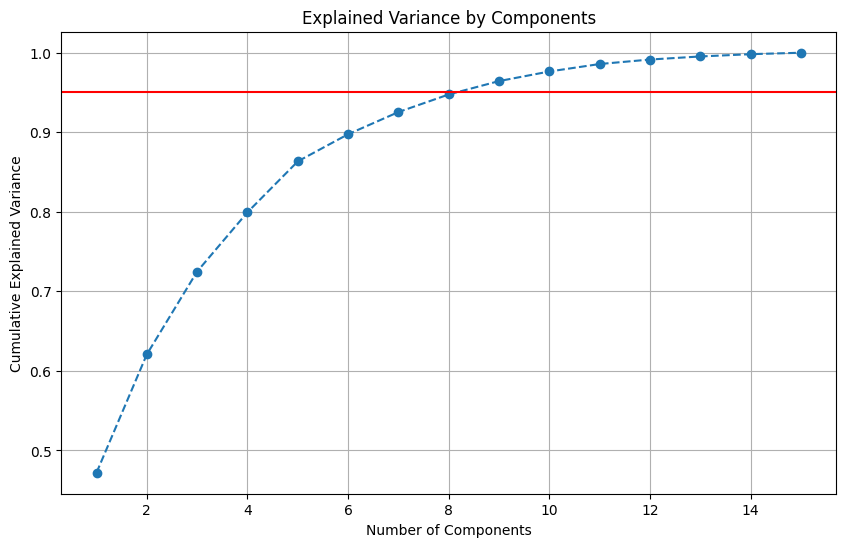

In [51]:
# Fit PCA
pca = PCA().fit(X_df_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [52]:
# Find the number of components that cover around 90% of the variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Number of components to cover around 90% of the variance: {n_components}')

Number of components to cover around 90% of the variance: 9


In [53]:
# Transform the data using the optimal number of components
X_reduced = PCA(n_components=n_components).fit_transform(X_df_scaled)

# Create a DataFrame with the reduced data
principalDf = pd.DataFrame(data=X_reduced)
print(principalDf.head(10))

          0         1         2         3         4         5         6  \
0  0.940889 -0.181963 -0.716503  0.123161 -0.182026  0.092684 -0.056400   
1  0.917970 -0.184337 -0.722219  0.142343 -0.199293  0.094129 -0.066682   
2  1.014027 -0.258317 -0.520348 -0.652627  0.281745  0.045885  0.003059   
3 -0.857151 -0.381727  0.107079  0.038964 -0.189092 -0.020549  0.141581   
4  0.964053 -0.231758 -0.553620 -0.145307 -0.003880  0.187115  0.031966   
5  1.012002 -0.226206 -0.464880 -0.502912  0.221470  0.042031 -0.002662   
6  0.960155 -0.181190 -0.573279  0.015770 -0.159379  0.289216  0.069565   
7  0.992727 -0.169214 -0.386846 -0.486289  0.286577 -0.022725 -0.013688   
8 -0.712337 -0.458905 -0.004523  0.200858 -0.098861 -0.036217  0.220733   
9 -0.342693 -0.291803 -0.100699  0.275114  0.124900 -0.136262  0.146778   

          7         8  
0  0.358450 -0.077170  
1  0.356212 -0.063430  
2 -0.210795  0.033078  
3 -0.001754  0.030465  
4 -0.133461 -0.018460  
5 -0.194415  0.056091  
6 -0.1

### Splitting train and test

In [54]:
# Split the dataset into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(principalDf, Y_df, test_size=0.2, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_df, Y_df, test_size=0.2, random_state=21)



In [55]:

# Find unique classes in y_train
unique_classes = np.unique(Y_train)

# Count the number of unique classes
num_classes = len(unique_classes)

print("Number of different classes in y_train:", num_classes)
print("Unique classes:", unique_classes)

Number of different classes in y_train: 3
Unique classes: [1 2 3]


### Changing to the next lower value if the particular category does not have 2 datasets

In [56]:
# Count the occurrences of each category in y_train
category_counts = Y_train.value_counts().sort_index()

# Print the number of data points for each category
for category, count in category_counts.items():
    print(f"Category {category}: {count} data points")

Category 1: 27 data points
Category 2: 5 data points
Category 3: 8 data points


In [57]:
# Find the highest value in y_train
highest_value = Y_train.max()

# Iterate from the highest value in y_train and decrement if its count is less than or equal to 2
for category in range(highest_value, 0, -1):
    count = (Y_train == category).sum()
    if count <= 2 and category > 1:
        Y_train[Y_train == category] = category - 1

# Print the updated number of data points for each category
updated_category_counts = Y_train.value_counts().sort_index()
for category, count in updated_category_counts.items():
    print(f"Category {category}: {count} data points")

Category 1: 27 data points
Category 2: 5 data points
Category 3: 8 data points


In [58]:
!pip install scikit-learn==1.0.2 imbalanced-learn==0.8.0





Defaulting to user installation because normal site-packages is not writeable


In [59]:
pip install scikit-learn==1.0.2 imbalanced-learn==0.8.0 joblib==1.1.0


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from imblearn.over_sampling import SMOTE
import pickle

### SMOTE

In [61]:
# Apply SMOTE to oversample the minority classes
smote = SMOTE(random_state=35, k_neighbors=2)   
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, Y_train)

In [62]:
print("Shape of Y_df:", Y_df.shape)
print("Shape of Y_train before reshaping:", Y_train.shape)
print("Shape of Y_test before reshaping:", Y_test.shape)

# Reshape Y_train and Y_test to have a single column
Y_train_reshaped = np.reshape(Y_train.values, (-1, 1))
Y_test_reshaped = np.reshape(Y_test.values, (-1, 1))

Shape of Y_df: (50,)
Shape of Y_train before reshaping: (40,)
Shape of Y_test before reshaping: (10,)


# classification models

### Random Forest Model

In [63]:
# Choose a Model
ensemble_size_random_forest_model = RandomForestClassifier()

# # Train the model
ensemble_size_random_forest_model.fit(X_train, Y_train)

# Evaluate the model
y_val_pred = ensemble_size_random_forest_model.predict(X_test)

# Combine y_val and y_val_pred into a DataFrame for comparison
comparison_df = pd.DataFrame({'Actual': Y_test, 'Random_forst_Predicted': y_val_pred})
print(comparison_df)

    Actual  Random_forst_Predicted
7        2                       1
44       1                       3
43       1                       3
25       1                       3
14       1                       1
2        2                       1
23       1                       3
31       1                       1
17       1                       1
47       3                       3


### Random Forest Model with SMOTE

In [64]:


# Choose a Model
ensemble_size_random_forest_with_smote_model = RandomForestClassifier()

# # Train the model
ensemble_size_random_forest_with_smote_model.fit(X_train_resampled, y_train_resampled)

# Define the number of folds for cross-validation
num_folds = 5  

# Define the cross-validation strategy
cross_val_strategy = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation prediction
y_val_pred_cv = cross_val_predict(ensemble_size_random_forest_with_smote_model, X_test, Y_test, cv=cross_val_strategy)

# Add the to the existing comparison_df
comparison_df['Random_forst_smote_Prediction'] = y_val_pred_cv

comparison_df

/home/theepana/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,Actual,Random_forst_Predicted,Random_forst_smote_Prediction
7,2,1,1
44,1,3,1
43,1,3,3
25,1,3,1
14,1,1,1
2,2,1,2
23,1,3,1
31,1,1,3
17,1,1,1
47,3,3,1


### Logistic regression model

In [65]:
#Choose a Model
ensemble_size_logistic_regression_model = LogisticRegression()

# Train the model
ensemble_size_logistic_regression_model.fit(X_train, Y_train)

# Evaluate the model
y_val_pred_logistic = ensemble_size_logistic_regression_model.predict(X_test)

# Add the logistic regression predictions to the existing comparison_df
comparison_df['Logistic_Predicted'] = y_val_pred_logistic

# Print the updated DataFrame
comparison_df

,Actual,Random_forst_Predicted,Random_forst_smote_Prediction,Logistic_Predicted
7,2,1,1,1
44,1,3,1,3
43,1,3,3,3
25,1,3,1,1
14,1,1,1,1
2,2,1,2,1
23,1,3,1,1
31,1,1,3,1
17,1,1,1,1
47,3,3,1,3


### Logistic regression model with SMOTE

In [66]:
#Choose a Model
ensemble_size_logistic_regression_with_smote_model = LogisticRegression()

# # Train the model
ensemble_size_logistic_regression_with_smote_model.fit(X_train_resampled, y_train_resampled)

# Define the number of folds for cross-validation
num_folds = 5  

# Define the cross-validation strategy
cross_val_strategy = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation prediction
y_val_pred_cv = cross_val_predict(ensemble_size_logistic_regression_with_smote_model, X_test, Y_test, cv=cross_val_strategy)

# Add the to the existing comparison_df
comparison_df['Logistic_smote_Prediction'] = y_val_pred_cv

comparison_df

/home/theepana/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,Actual,Random_forst_Predicted,Random_forst_smote_Prediction,Logistic_Predicted,Logistic_smote_Prediction
7,2,1,1,1,1
44,1,3,1,3,1
43,1,3,3,3,1
25,1,3,1,1,1
14,1,1,1,1,1
2,2,1,2,1,1
23,1,3,1,1,1
31,1,1,3,1,1
17,1,1,1,1,1
47,3,3,1,3,1


### Support Vector Machine

In [67]:
# Choose a Model
ensemble_size_svm_model = SVC()

# Train the model
ensemble_size_svm_model.fit(X_train, Y_train)

# Evaluate the model
y_val_pred_svm = ensemble_size_svm_model.predict(X_test)

# Add the SVM predictions to the existing comparison_df
comparison_df['SVM_Predicted'] = y_val_pred_svm

# Print the updated DataFrame
comparison_df

,Actual,Random_forst_Predicted,Random_forst_smote_Prediction,Logistic_Predicted,Logistic_smote_Prediction,SVM_Predicted
7,2,1,1,1,1,1
44,1,3,1,3,1,1
43,1,3,3,3,1,1
25,1,3,1,1,1,1
14,1,1,1,1,1,1
2,2,1,2,1,1,1
23,1,3,1,1,1,1
31,1,1,3,1,1,1
17,1,1,1,1,1,1
47,3,3,1,3,1,1


### Support Vector Machine with SMOTE

In [68]:

#Choose a Model
ensemble_size_svm_with_smote_model = SVC()

# # Train the model
ensemble_size_svm_with_smote_model.fit(X_train_resampled, y_train_resampled)

# Define the number of folds for cross-validation
num_folds = 5  

# Define the cross-validation strategy
cross_val_strategy = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation prediction
y_val_pred_cv = cross_val_predict(ensemble_size_svm_with_smote_model, X_test, Y_test, cv=cross_val_strategy)

# Add the to the existing comparison_df
comparison_df['SVM_smote_Prediction'] = y_val_pred_cv

comparison_df

/home/theepana/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,Actual,Random_forst_Predicted,Random_forst_smote_Prediction,Logistic_Predicted,Logistic_smote_Prediction,SVM_Predicted,SVM_smote_Prediction
7,2,1,1,1,1,1,1
44,1,3,1,3,1,1,1
43,1,3,3,3,1,1,1
25,1,3,1,1,1,1,1
14,1,1,1,1,1,1,1
2,2,1,2,1,1,1,1
23,1,3,1,1,1,1,1
31,1,1,3,1,1,1,1
17,1,1,1,1,1,1,1
47,3,3,1,3,1,1,1


In [69]:
# Save the model as a pickle file
model_directory = "../model_pickle/ensemble_size" 
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

### Delete the already existing pickle file from the directory

In [70]:
def delete_files_in_directory(directory):
    try:
        # List all files in the directory
        files = os.listdir(directory)
        
        # Iterate over each file
        for file_name in files:
            # Construct the full file path
            file_path = os.path.join(directory, file_name)
            
            # Check if the path is a file (not a directory)
            if os.path.isfile(file_path):
                # Delete the file
                os.remove(file_path)
                print(f"Deleted: {file_path}")
    
    except Exception as e:
        print(f"An error occurred: {e}")


delete_files_in_directory(model_directory)

Deleted: ../model_pickle/ensemble_size/svm_model.pkl


In [71]:
# Total number of predictions (total rows)
total_predictions = comparison_df.shape[0]

# Number of correctly classified predictions for each model
correct_random_forest = (comparison_df['Actual'] == comparison_df['Random_forst_Predicted']).sum()
correct_logistic_regression = (comparison_df['Actual'] == comparison_df['Logistic_Predicted']).sum()
correct_svm = (comparison_df['Actual'] == comparison_df['SVM_Predicted']).sum()
correct_random_forest_with_smote = (comparison_df['Actual'] == comparison_df['Random_forst_smote_Prediction']).sum()
correct_logistic_regression_with_smote = (comparison_df['Actual'] == comparison_df['Logistic_smote_Prediction']).sum()
correct_svm_with_smote = (comparison_df['Actual'] == comparison_df['SVM_smote_Prediction']).sum()

# Print the results
print("Total predictions:", total_predictions)
print("Correctly classified predictions for Random Forest:", correct_random_forest)
print("Correctly classified predictions for Logistic Regression:", correct_logistic_regression)
print("Correctly classified predictions for SVM:", correct_svm)
print("Correctly classified predictions for Random Forest with smote:", correct_random_forest_with_smote)
print("Correctly classified predictions for Logistic Regression with smote:", correct_logistic_regression_with_smote)
print("Correctly classified predictions for SVM with smote:", correct_svm_with_smote)


Total predictions: 10
Correctly classified predictions for Random Forest: 4
Correctly classified predictions for Logistic Regression: 6
Correctly classified predictions for SVM: 7
Correctly classified predictions for Random Forest with smote: 6
Correctly classified predictions for Logistic Regression with smote: 7
Correctly classified predictions for SVM with smote: 7


### Storing the pickle file of the model with highest number of predictions

In [72]:
# Determine which model has the highest number of correct predictions
models_correct = {
    'Random Forest': correct_random_forest,
    'Logistic Regression': correct_logistic_regression,
    'SVM': correct_svm,
    'Random Forest with SMOTE': correct_random_forest_with_smote,
    'Logistic Regression with SMOTE': correct_logistic_regression_with_smote,
    'SVM with SMOTE': correct_svm_with_smote,
}

best_model = max(models_correct, key=models_correct.get)

# Save the corresponding model to a pickle file
if best_model == 'Random Forest':
    model_filename = os.path.join(model_directory, 'random_forest_model.pkl')
    with open(model_filename, 'wb') as f:
        pickle.dump(ensemble_size_random_forest_model, f)
    print("Random Forest model saved as:", model_filename)
elif best_model == 'Random Forest with SMOTE':
    model_filename = os.path.join(model_directory, 'random_forest_with_smote_model.pkl')
    with open(model_filename, 'wb') as f:
        pickle.dump(ensemble_size_random_forest_with_smote_model, f)
    print("Random Forest with SMOTE model saved as:", model_filename)
elif best_model == 'Logistic Regression':
    model_filename = os.path.join(model_directory, 'logistic_regression_model.pkl')
    with open(model_filename, 'wb') as f:
        pickle.dump(ensemble_size_logistic_regression_model, f)
    print("Logistic Regression model saved as:", model_filename)
elif best_model == 'SVM':
    model_filename = os.path.join(model_directory, 'svm_model.pkl')
    with open(model_filename, 'wb') as f:
        pickle.dump(ensemble_size_svm_model, f)
    print("SVM model saved as:", model_filename)

elif best_model == 'Logistic Regression with SMOTE':
    model_filename = os.path.join(model_directory, 'logistic_regression_with_smote_model.pkl')
    with open(model_filename, 'wb') as f:
        pickle.dump(ensemble_size_logistic_regression_with_smote_model, f)
    print("Logistic Regression with SMOTE model saved as:", model_filename)
elif best_model == 'SVM with SMOTE':
    model_filename = os.path.join(model_directory, 'svm_with_smote_model.pkl')
    with open(model_filename, 'wb') as f:
        pickle.dump(ensemble_size_svm_with_smote_model, f)
    print("SVM with SMOTE model saved as:", model_filename)

SVM model saved as: ../model_pickle/ensemble_size/svm_model.pkl
